### PERSISTENCE MODEL

In [1]:
import pandas as pd
import numpy as np
import os
import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from math import sqrt

In [2]:
def load_data(years = ['2013','2014','2015']):
    file_name_1 = 'elspot-prices_'
    file_name_2 = '_hourly_dkk.csv'
    data_folder = os.getcwd().replace('notebook','data\\')
    all_data=[]
    for year in years:
        file_name_tot = data_folder + file_name_1 + year + file_name_2
        all_data.append(pd.read_csv(file_name_tot,encoding = "ISO-8859-1",sep=';',decimal=','))
    df = pd.concat(all_data, ignore_index=True,sort= True)
    return df
    

In [3]:
df = load_data()
df.head()

,Bergen,DK1,DK2,EE,ELE,FI,FRE,Hours,Kr.sand,LT,...,Molde,Oslo,SE1,SE2,SE3,SE4,SYS,Tr.heim,Tromsø,datetime
0,246.01,104.66,104.66,232.14,232.14,231.54,NaN,00 - 01,246.01,182.16,...,231.54,246.01,231.54,231.54,231.54,231.54,231.62,231.54,231.54,01/01/2013
1,245.94,82.50,82.50,228.34,228.34,205.21,NaN,01 - 02,245.94,176.19,...,229.83,245.94,205.21,205.21,205.21,205.21,227.29,229.83,229.83,01/01/2013
2,243.11,63.41,63.41,182.31,182.31,182.31,NaN,02 - 03,243.11,178.51,...,229.53,243.11,182.31,182.31,182.31,182.31,215.73,229.53,229.53,01/01/2013
3,235.20,0.75,0.75,162.69,162.69,162.69,NaN,03 - 04,235.20,177.91,...,229.08,235.20,162.69,162.69,162.69,162.69,207.97,229.08,229.08,01/01/2013
4,227.81,14.99,14.99,166.87,166.87,166.87,NaN,04 - 05,227.81,173.51,...,228.48,227.81,166.87,166.87,166.87,166.87,201.11,228.48,228.48,01/01/2013


In [14]:
def generate_shifted_features(df,time_shift,colname):
    pd.options.mode.chained_assignment = None
    df = df[['datetime','Hours','Bergen']]
    for t in time_shift:
        df.loc[:,colname+'_'+str(t)] = df.Bergen.shift(t)
    return df

In [5]:
time_shift = [1]
df_bergen = generate_shifted_features(df,time_shift,'Bergen')
df_bergen.head()

,datetime,Hours,Bergen,Bergen_1
0,01/01/2013,00 - 01,246.01,NaN
1,01/01/2013,01 - 02,245.94,246.01
2,01/01/2013,02 - 03,243.11,245.94
3,01/01/2013,03 - 04,235.20,243.11
4,01/01/2013,04 - 05,227.81,235.20


In [6]:
def create_train_test(df,test_size = 8000):
    df = df.dropna()
    train_size = df.shape[0]-test_size
    
    X_train = df.drop(['Bergen','Hours','datetime'],axis=1).head(train_size)
    y_train = df['Bergen'].head(train_size)
    X_test = df.drop(['Bergen','Hours','datetime'],axis=1).tail(test_size)
    y_test = df['Bergen'].tail(test_size)
    
    return X_train, y_train, X_test, y_test
    

In [7]:
X_train, y_train, X_test, y_test = create_train_test(df_bergen,test_size = 8000)
X_train.head()

,Bergen_1
1,246.01
2,245.94
3,243.11
4,235.20
5,227.81


In [27]:
def baseline_model(X_test, y_test):
    y_pred = X_test
    return y_pred

In [28]:
def predict_baseline_model(X_test,y_test):
    y_pred = baseline_model(X_test, y_test)
    mae = mean_absolute_error(y_test,y_pred)
    rmse = sqrt(mean_squared_error(y_test,y_pred))
    print('MAE = {:.2f}, RMSE = {:.2f}'.format(mae,rmse))
    return y_pred,mae,rmse
    

In [10]:
y_pred, mae, rmse = predict_baseline_model()

MAE = 4.76, RMSE = 10.96


In [11]:
def plot_predictions(y_test = y_test, y_pred = y_pred,plot_samples=100,size=(15,5)):
    plt.figure(figsize=size)
    plt.title('Example of model predictions')
    plt.scatter(range(plot_samples),y_test[:plot_samples],color='b')
    plt.scatter(range(plot_samples),y_pred[:plot_samples],color='r')
    plt.show()
    return

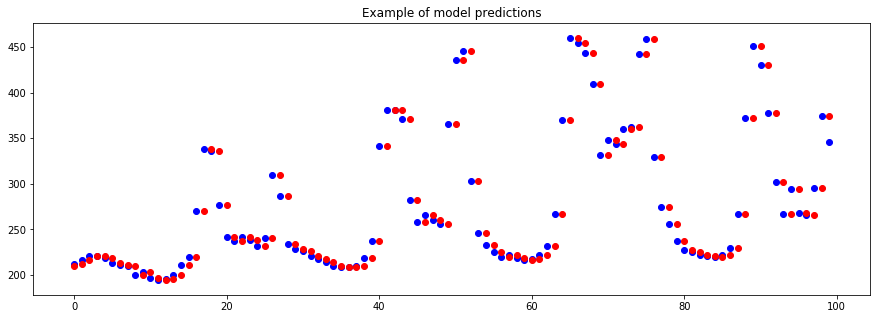

In [12]:
plot_predictions()

### HOW DISTANCE IN TIME AFFECTS PERFORMANCE 

In [30]:
time_shift = [2]
df_2 = generate_shifted_features(df,time_shift,'Bergen')
df_2.head()

,datetime,Hours,Bergen,Bergen_2
0,01/01/2013,00 - 01,246.01,NaN
1,01/01/2013,01 - 02,245.94,NaN
2,01/01/2013,02 - 03,243.11,246.01
3,01/01/2013,03 - 04,235.20,245.94
4,01/01/2013,04 - 05,227.81,243.11


In [31]:
X_train, y_train, X_test, y_test = create_train_test(df_2,test_size = 8000)
X_test.head()

,Bergen_2
18281,210.21
18282,209.98
18283,211.92
18284,216.01
18285,220.63


In [32]:
y_test.head()

18281    211.92
18282    216.01
18283    220.63
18284    220.85
18285    218.99
Name: Bergen, dtype: float64

In [33]:
y_pred, mae, rmse = predict_baseline_model(X_test,y_test)

MAE = 8.61, RMSE = 17.24
